<a href="https://colab.research.google.com/github/lauraosede/CE888/blob/main/Lab_8/TL_FE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "lauraosede" # username from the json file
os.environ['KAGGLE_KEY'] = "7d2ff1d844dbe8e88a5721c6f2bacae8" # key from the json file
!kaggle competitions download -c dogs-vs-cats # api copied from kaggle (https://www.kaggle.com/c/dogs-vs-cats/data)


  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 76.5MB/s]
 99% 537M/543M [00:02<00:00, 173MB/s]
100% 543M/543M [00:02<00:00, 196MB/s]
 94% 254M/271M [00:01<00:00, 213MB/s]
100% 271M/271M [00:01<00:00, 220MB/s]


In [ ]:
# Unzip training data
from zipfile import ZipFile
file_name = "/content/train.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
# Get all the paths
data_dir_list = os.listdir('/content/train')
#print(data_dir_list)
path, dirs, files = next(os.walk("/content/train"))
file_count = len(files)
print(file_count)

25000


In [ ]:
# Make new base directory
original_dataset_dir = '/content/train'
base_dir = '/content/cats_and_dogs_small'
os.mkdir(base_dir)

In [ ]:
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [ ]:
import shutil
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
import cv2
import numpy as np
from random import shuffle

IMG_SIZE = 224
LR = 1e-4

In [ ]:
def label_img(img):
    word_label = img.split('.')[0]
    if word_label == 'dog': return 1
    elif word_label == 'cat': return 0

In [ ]:
def createDataSplitSet(datapath):
    X=[]
    y=[]

    for img in os.listdir(datapath):
        label = label_img(img)
        # print(label)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(np.array(image))
        y.append(label)

    return np.array(X), np.array(y)

In [ ]:
train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)

In [ ]:
## VGG 16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [ ]:
model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax")
model.summary()

553467904/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
last_layer = model.get_layer('fc2').output
out = Dense(1, activation='sigmoid', name='output')(last_layer)  ## 2 classes
model = Model(img_input, out)

for layer in model.layers[:-1]:
	layer.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='vgg16_model.h5', save_best_only=True),
]

In [ ]:
history = model.fit(train_X, train_y,
                               batch_size=10,
                               epochs=10, 
                               validation_data=(val_X, val_y),
                               callbacks=my_callbacks)

Epoch 1/10
200/200 [==============================] - 26s 47ms/step - loss: 0.6591 - acc: 0.6582 - val_loss: 0.3717 - val_acc: 0.8350
Epoch 2/10
200/200 [==============================] - 9s 45ms/step - loss: 0.3366 - acc: 0.8610 - val_loss: 0.2664 - val_acc: 0.8900
Epoch 3/10
200/200 [==============================] - 9s 45ms/step - loss: 0.2773 - acc: 0.8855 - val_loss: 0.2714 - val_acc: 0.8780
Epoch 4/10
200/200 [==============================] - 9s 45ms/step - loss: 0.2553 - acc: 0.8956 - val_loss: 0.2303 - val_acc: 0.9040
Epoch 5/10
200/200 [==============================] - 9s 45ms/step - loss: 0.2504 - acc: 0.8924 - val_loss: 0.2260 - val_acc: 0.8970
Epoch 6/10
200/200 [==============================] - 9s 45ms/step - loss: 0.2674 - acc: 0.8723 - val_loss: 0.2537 - val_acc: 0.8810
Epoch 7/10
200/200 [==============================] - 9s 45ms/step - loss: 0.2368 - acc: 0.9067 - val_loss: 0.2263 - val_acc: 0.8960
Epoch 8/10
200/200 [==============================] - 9s 45ms/step -

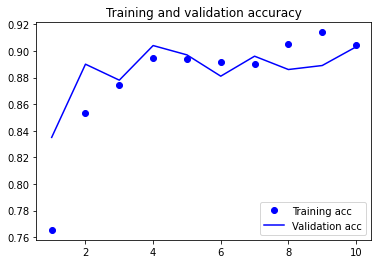

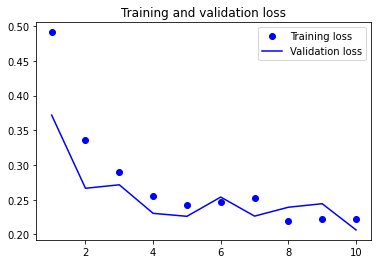

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Implementing feautre extraction on dataset

imports

In [ ]:
%matplotlib inline

import os
import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Make new base directory
original_dataset_dir = '/content/drive/MyDrive/data science /ds/data/comb'
base_dir_ft = '/content/drive/MyDrive/data science /ds/data/cats_dogs_horses_human'
#os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
#os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
#os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
#os.mkdir(test_dir)

Image visulaization

In [ ]:
img_width, img_height = 224, 224 
IMG_DIM = (img_width, img_height)

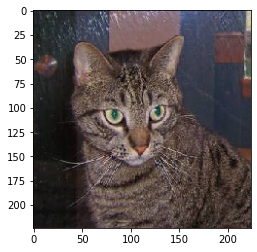

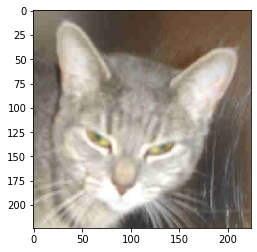

In [ ]:
# Show random images of cat ds
import os, random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image


def show_pictures(path):
    random_img = random.choice(cats_dir)
    img_path = os.path.join('/content/drive/MyDrive/data science /ds/data/cats', random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(cats_dir)

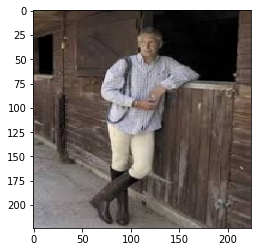

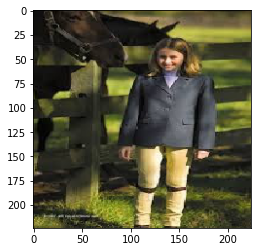

In [ ]:
# Show random images of human ds
import os, random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

def show_pictures(path):
    random_img = random.choice(Humans_dir)
    img_path = os.path.join('/content/drive/MyDrive/data science /ds/data/Humans', random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(Humans_dir)

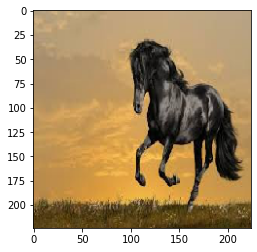

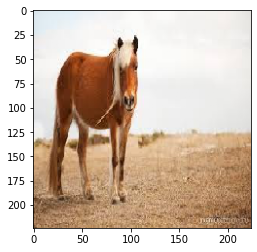

In [ ]:
# Show random images of horse ds
import os, random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

def show_pictures(path):
    random_img = random.choice(horses_dir)
    img_path = os.path.join('/content/drive/MyDrive/data science /ds/data/horses', random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(horses_dir)

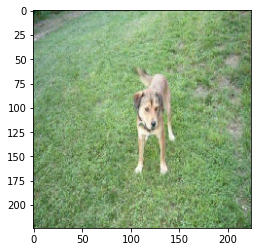

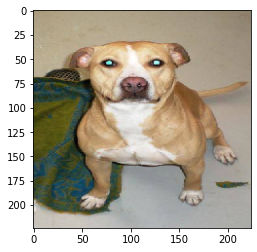

In [ ]:
# Show random images of dog ds
import os, random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

def show_pictures(path):
    random_img = random.choice(dogs_dir)
    img_path = os.path.join('/content/drive/MyDrive/data science /ds/data/dogs', random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(dogs_dir)

Spliting data into train, test and validation sets

In [ ]:
import shutil
#cats
fnames = ['cat.{}.jpg'.format(i) for i in range(1, 100)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(100,150)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(150,200)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

#dogs
fnames = ['dog.{}.jpg'.format(i) for i in range(1,100)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(100,150)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(150, 200)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)


#humans
fnames = ['rider-{}.jpg'.format(i) for i in range(1, 100)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname, )
    dst = os.path.join(train_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
fnames = ['rider-{}.jpg'.format(i) for i in range(100 - 150)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['rider-{}.jpg'.format(i) for i in range(150, 200)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

#horses
fnames = ['horse-{}.jpg'.format(i) for i in range(1 - 100)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['horse-{}.jpg'.format(i) for i in range(100, 150)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['horse-{}.jpg'.format(i) for i in range(150, 200)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
import numpy as np
from random import shuffle

IMG_SIZE = 224
LR = 1e-4

In [ ]:
def label_img(img):
    word_label = img.split('.')[0]
    if word_label == 'dog': return 1
    elif word_label == 'cat': return 0

In [ ]:
import cv2
def createDataSplitSet(datapath):
    X=[]
    y=[]
    for img in os.listdir(datapath):
        label = label_img(img)
        # print(label)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(np.array(image))
        y.append(label)
    return np.array(X), np.array(y)

In [ ]:
train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)
print(train_X.shape)
print(val_X.shape)
print(test_X.shape)

(297, 224, 224, 3)
(150, 224, 224, 3)
(200, 224, 224, 3)


### Feature Extraction with ResNet50

In [ ]:
!pip install tensorflow-addons

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import tensorflow.keras as keras

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(img_height,img_width,3),pooling='max')

output = resnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)

res_name = []
for layer in resnet.layers:
    res_name.append(layer.name)


In [ ]:
res_name[-22:]

['conv5_block2_1_conv',
 'conv5_block2_1_bn',
 'conv5_block2_1_relu',
 'conv5_block2_2_conv',
 'conv5_block2_2_bn',
 'conv5_block2_2_relu',
 'conv5_block2_3_conv',
 'conv5_block2_3_bn',
 'conv5_block2_add',
 'conv5_block2_out',
 'conv5_block3_1_conv',
 'conv5_block3_1_bn',
 'conv5_block3_1_relu',
 'conv5_block3_2_conv',
 'conv5_block3_2_bn',
 'conv5_block3_2_relu',
 'conv5_block3_3_conv',
 'conv5_block3_3_bn',
 'conv5_block3_add',
 'conv5_block3_out',
 'max_pool',
 'flatten_1']

In [ ]:
set_trainable = False
for layer in resnet.layers:
    if layer.name in res_name[-22:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
resnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

num_classes = 120

model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               123000    
Total params: 26,858,488
Trainable params: 12,202,104
Non-trainable params: 14,656,384
_________________________________

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,
                                              restore_best_weights=False
                                              )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=4,
                                   verbose=1,
                                   min_delta=5*1e-3,min_lr = 5*1e-7,
                                   )

In [ ]:
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy',tfa.metrics.F1Score(num_classes=num_classes)])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='vgg16_model.h5', save_best_only=True),
]